In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError, R2Score


df_not_outliers = pd.read_csv('../intermedio_sin_outliers.csv')

X_sin_outliers = df_not_outliers.drop(columns=['Precio_usd'])
y_sin_outliers = df_not_outliers['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled_sin_outliers = scaler.fit_transform(X_sin_outliers)

# Split sin outliers
X_train_sin_outliers, X_test_sin_outliers, y_train_sin_outliers, y_test_sin_outliers = train_test_split(
    X_scaled_sin_outliers, y_sin_outliers, test_size=0.2, random_state=42
)


In [ ]:
# Modelo
def build_model2(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train_sin_outliers.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=[
            'mae',
            RootMeanSquaredError(name='rmse'),
            R2Score(name='r2')
        ]
    )
    return model

# Tuner
tuner2 = kt.RandomSearch(
    build_model2,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar mejores hiperparámetros
tuner2.search(
    X_train_sin_outliers, y_train_sin_outliers,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Mejor modelo
best_model_sinOutlier = tuner2.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 15s]
val_mae: 2319.794677734375

Best val_mae So Far: 2265.575439453125
Total elapsed time: 00h 02m 40s


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Recuperar los mejores hiperparámetros
best_hp3 = tuner2.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model2 = build_model2(best_hp3)
history2 = model2.fit(
    X_train_sin_outliers, y_train_sin_outliers,
    validation_data=(X_test_sin_outliers, y_test_sin_outliers),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step - loss: 17026.4160 - mae: 17020.5449 - r2: -3.0799 - rmse: 20631.8418 - val_loss: 3664.9197 - val_mae: 3649.7771 - val_r2: 0.7659 - val_rmse: 5172.7876
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 3922.0068 - mae: 3906.2375 - r2: 0.7416 - rmse: 5383.8848 - val_loss: 2742.9026 - val_mae: 2725.8223 - val_r2: 0.8563 - val_rmse: 4053.1833
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 3566.9075 - mae: 3549.4985 - r2: 0.7867 - rmse: 4880.9048 - val_loss: 2650.5256 - val_mae: 2632.2939 - val_r2: 0.8596 - val_rmse: 4006.1204
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 3421.7056 - mae: 3403.0618 - r2: 0.7931 - rmse: 4757.8960 - val_loss: 2650.5203 - val_mae: 2630.9885 - val_r2: 0.8669 - val_rmse: 3901.3535
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 3413.9150 - mae: 3394.2390 - r2: 0.8027 - rmse: 4673.8218 - val_loss: 2607.6970 - val_mae: 2587.2839 - val_r2: 0.8644 - val_rm

In [ ]:
print (best_hp3.values)
print (best_hp3)

{'units_1': 192, 'dropout_1': 0.30000000000000004, 'units_2': 112, 'dropout_2': 0.30000000000000004, 'units_3': 32, 'lr': 0.01}


In [ ]:
y_pred = model2.predict(X_test_sin_outliers).flatten()

mae = mean_absolute_error(y_test_sin_outliers, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_sin_outliers, y_pred))
r2 = r2_score(y_test_sin_outliers, y_pred)
mape = np.mean(np.abs((y_test_sin_outliers - y_pred) / y_test_sin_outliers)) * 100

print(f"\n--- MÉTRICAS ---")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R2: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")



106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step

--- MÉTRICAS ---
MAE: $2,278
RMSE: $3,469
R2: 0.895
MAPE: 10.27%


In [ ]:
dataset1 = pd.read_csv('../dataset_basico.csv')

X1, y1 = dataset1.drop(columns='Precio_usd'), dataset1['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X1)

# Split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled, y1, test_size=0.2, random_state=42)


In [ ]:
# Modelo
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train1.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=[
            'mae',
            RootMeanSquaredError(name='rmse'),
            R2Score(name='r2')
        ]
    )
    return model

# Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar
tuner.search(X_train1, y_train1, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 14s]
val_mae: 3226.196044921875

Best val_mae So Far: 3188.263427734375
Total elapsed time: 00h 02m 32s


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
y_pred = best_model.predict(X_test1).flatten()

mae = mean_absolute_error(y_test1, y_pred)
rmse = np.sqrt(mean_squared_error(y_test1, y_pred))
r2 = r2_score(y_test1, y_pred)
mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100

print(f"\n--- MÉTRICAS ---")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R2: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step

--- MÉTRICAS ---
MAE: $3,102
RMSE: $4,741
R2: 0.801
MAPE: 12.95%


In [ ]:
# Recuperar los mejores hiperparámetros
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model1 = build_model(best_hp)
history1 = model1.fit(
    X_train1, y_train1,
    validation_data=(X_test1, y_test1),
    epochs=50,
    batch_size=32,
    verbose=1
)
print(best_hp.values)
print(best_hp)

Epoch 1/50


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 24731.7988 - mae: 24731.3984 - r2: -5.3791 - rmse: 26933.7559 - val_loss: 23285.2461 - val_mae: 23283.4434 - val_r2: -4.8015 - val_rmse: 25582.4473
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 21084.5742 - mae: 21081.5723 - r2: -4.0860 - rmse: 23619.3320 - val_loss: 12514.0723 - val_mae: 12506.0869 - val_r2: -1.3175 - val_rmse: 16168.7930
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 10576.5293 - mae: 10566.8564 - r2: -0.8201 - rmse: 14193.7666 - val_loss: 5180.0913 - val_mae: 5166.6348 - val_r2: 0.5014 - val_rmse: 7500.0947
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 6111.7617 - mae: 6097.7764 - r2: 0.3937 - rmse: 8227.1309 - val_loss: 3969.4089 - val_mae: 3954.7483 - val_r2: 0.7187 - val_rmse: 5632.7681
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 5873.9248 - mae: 5859.1406 - r2: 0.4673 - rmse: 7760.0410 - val_loss: 3857.0576 - val_mae: 3842.2300 - val_r2: 0.7465 - val

In [ ]:
dataset1 = pd.read_csv('../dataset_final.csv')

X2, y2 = dataset1.drop(columns='Precio_usd'), dataset1['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled2 = scaler.fit_transform(X2)

# Split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled2, y2, test_size=0.2, random_state=42)


In [ ]:
# Modelo
def build_model3(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train2.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=[
            'mae',
            RootMeanSquaredError(name='rmse'),
            R2Score(name='r2')
        ]
    )
    return model

# Tuner
tuner3 = kt.RandomSearch(
    build_model3,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar
tuner3.search(X_train2, y_train2, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Mejor modelo
best_model = tuner3.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 16s]
val_mae: 2791.365234375

Best val_mae So Far: 2620.75634765625
Total elapsed time: 00h 02m 33s


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Recuperar los mejores hiperparámetros
best_hp3 = tuner3.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model3 = build_model3(best_hp3)
history3 = model3.fit(
    X_train2, y_train2,
    validation_data=(X_test2, y_test2),
    epochs=200,
    batch_size=32,
    verbose=1
)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - loss: 24444.2969 - mae: 24444.0352 - r2: -5.3455 - rmse: 26634.9043 - val_loss: 23920.3145 - val_mae: 23919.4297 - val_r2: -5.0124 - val_rmse: 26216.7188
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 23099.2949 - mae: 23097.8477 - r2: -4.8741 - rmse: 25426.8770 - val_loss: 19109.1953 - val_mae: 19105.5156 - val_r2: -3.2645 - val_rmse: 22079.4531
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 17292.3477 - mae: 17287.6113 - r2: -2.7879 - rmse: 20495.5781 - val_loss: 10287.2920 - val_mae: 10279.2207 - val_r2: -0.6750 - val_rmse: 13837.5879
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 8968.9414 - mae: 8959.8369 - r2: -0.3422 - rmse: 12053.2979 - val_loss: 4747.6914 - val_mae: 4736.3569 - val_r2: 0.5672 - val_rmse: 7034.1084
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 5841.2725 - mae: 5829.6543 - r2: 0.4627 - rmse: 7711.1094 - val_loss: 3312.9602 - val_mae: 3300.9351 - v

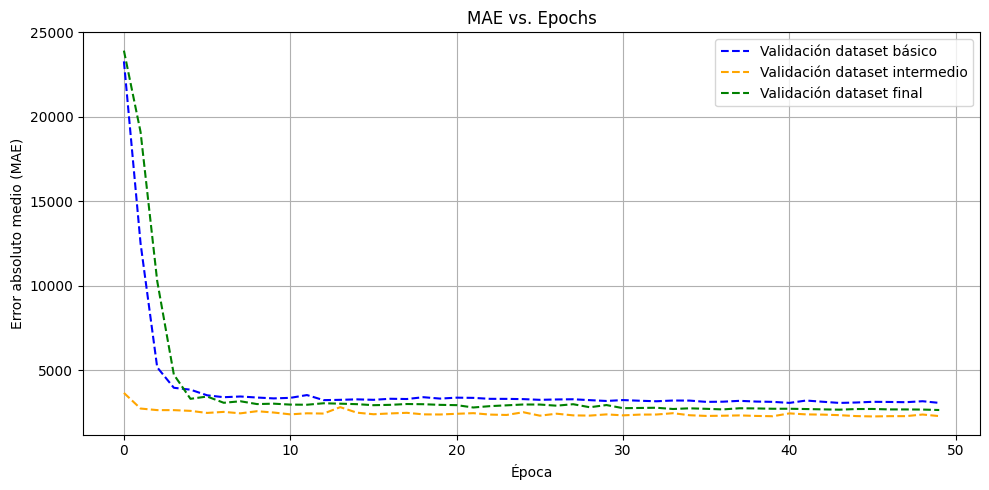

In [ ]:
plt.figure(figsize=(10, 5))
#plt.plot(history1.history['mae'], label='Entrenamiento dataset básico',color='blue')
plt.plot(history1.history['val_mae'], label='Validación dataset básico', linestyle='--', color='blue')
#plt.plot(history2.history['mae'], label='Entrenamiento dataset intermedio',color='Orange')
plt.plot(history2.history['val_mae'], label='Validación dataset intermedio',color='Orange', linestyle='--')
#plt.plot(history3.history['mae'], label='Entrenamiento dataset final',color='green')
plt.plot(history3.history['val_mae'], label='Validación dataset final', linestyle='--', color='green')
plt.title('MAE vs. Epochs')
plt.xlabel('Época')
plt.ylabel('Error absoluto medio (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


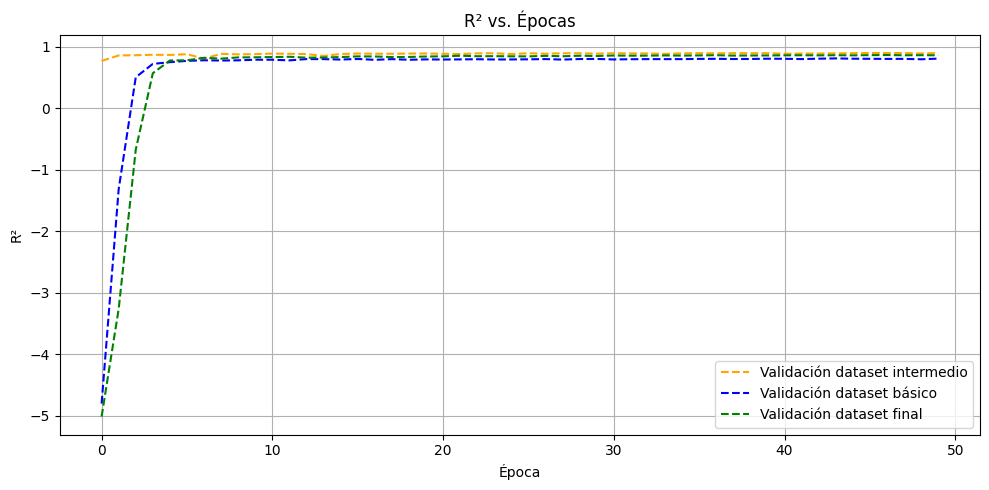

In [ ]:
plt.figure(figsize=(10, 5))
#plt.plot(history2.history['r2'], label='Entrenamiento dataset intermedio', color='orange')
plt.plot(history2.history['val_r2'], label='Validación dataset intermedio', linestyle='--', color='orange')
#plt.plot(history1.history['r2'], label='Entrenamiento dataset básico', color='blue')
plt.plot(history1.history['val_r2'], label='Validación dataset básico', linestyle='--', color='blue')
#plt.plot(history3.history['r2'], label='Entrenamiento dataset final', color='green')
plt.plot(history3.history['val_r2'], label='Validación dataset final', linestyle='--', color='green')
plt.title('R² vs. Épocas')
plt.xlabel('Época')
plt.ylabel('R²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

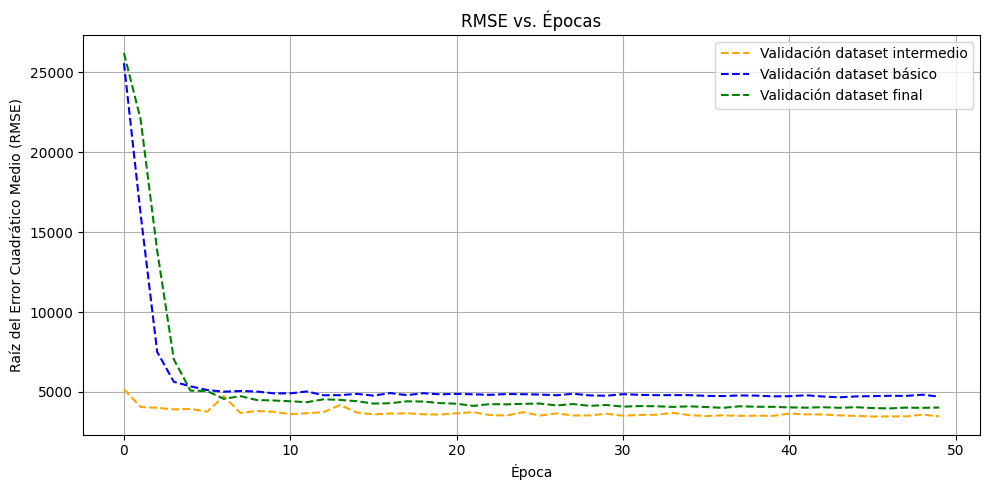

In [ ]:
plt.figure(figsize=(10, 5))
#plt.plot(history2.history['rmse'], label='Entrenamiento dataset intermedio', color='orange')
plt.plot(history2.history['val_rmse'], label='Validación dataset intermedio', linestyle='--', color='orange')
#plt.plot(history1.history['rmse'], label='Entrenamiento dataset básico', color='blue')
plt.plot(history1.history['val_rmse'], label='Validación dataset básico', linestyle='--', color='blue')
#plt.plot(history3.history['rmse'], label='Entrenamiento dataset final', color='green')
plt.plot(history3.history['val_rmse'], label='Validación dataset final', linestyle='--', color='green')
plt.title('RMSE vs. Épocas')
plt.xlabel('Época')
plt.ylabel('Raíz del Error Cuadrático Medio (RMSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from tabulate import tabulate
import pandas as pd
import numpy as np

# Supone que ya tenés mae, rmse, r2, history1, history2, history3 definidos

metrics = {
    'Modelo': ['Básico', 'Intermedio', 'Final'],
    'MAE': [
        np.mean(history1.history['mae']),
        np.mean(history2.history['mae']),
        np.mean(history3.history['mae']),
    ],
    'RMSE': [
        np.mean(history1.history['rmse']),
        np.mean(history2.history['rmse']),
        np.mean(history3.history['rmse']),
    ],
    'R²': [
        np.mean(history1.history['r2']),
        np.mean(history2.history['r2']),
        np.mean(history3.history['r2']),
    ],
}

df_metrics = pd.DataFrame(metrics)

# Imprimir en formato tabla bonito
print(tabulate(df_metrics, headers='keys', tablefmt='fancy_grid', showindex=False))



╒════════════╤═════════╤═════════╤══════════╕
│ Modelo     │     MAE │    RMSE │       R² │
╞════════════╪═════════╪═════════╪══════════╡
│ Básico     │ 5713.15 │ 7567.17 │ 0.373247 │
├────────────┼─────────┼─────────┼──────────┤
│ Intermedio │ 3280.05 │ 4590.44 │ 0.789926 │
├────────────┼─────────┼─────────┼──────────┤
│ Final      │ 5385.03 │ 6967.16 │ 0.391299 │
╘════════════╧═════════╧═════════╧══════════╛


In [ ]:
## prediciones con dataset final 
#importar 
import pandas as pd
dataset_final = pd.read_csv('../pf_dataset_test_final.csv')
print(dataset_final.dtypes)

#predicciones
predicciones = model2.predict(dataset_final).flatten()

df_predicciones = pd.DataFrame({'prediccion': predicciones})

# Exportar a CSV
df_predicciones.to_csv('predicciones_MLP.csv', index=False)

Año                           float64
Puertas                       float64
Con cámara de retroceso       float64
Kilómetros                    float64
Marca_Alfa Romeo              float64
                               ...   
Transmision_Manual            float64
Transmision_Semiautomática    float64
Vendedor_concesionaria        float64
Vendedor_particular           float64
Vendedor_tienda               float64
Length: 92, dtype: object
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
